2019
loading 361 filenames
361 is enough files


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


687307073


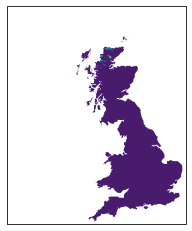

In [67]:
##################################################################
# This Script:
#    - Gets all 30 mins radar files for one year
#    - Joins them and masks out values over the sea
#    - Gets a 1D array of the data and removes masked out (over the sea
#      values) and np.nan values
##################################################################


##################################################################
# SET UP ENVIRONMENT
##################################################################
import iris.coord_categorisation
import iris
import numpy as np
import os
import geopandas as gpd
import sys
import matplotlib 
import numpy.ma as ma
import warnings
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
from matplotlib import colors
import glob as glob
import datetime
from iris.util import unify_time_units
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from iris.experimental.equalise_cubes import equalise_attributes

# Set up path to root directory
root_fp = "/nfs/a161/gy17m2a/PhD/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

resolution = '2.2km'
filtering_name='filtered_100'

gb_gdf = create_gb_outline({'init' :'epsg:3857'})

in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

season='wholeyear'

##################################################################
# FOR ONE YEAR AT A TIME
##################################################################
for year in range(2019, 2020):
    print(year)

    # Create directory to store outputs in and get general filename to load files from
    if resolution =='1km':
        ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/OriginalFormat_1km/"
        general_filename = f'datadir/NIMROD/30mins/OriginalFormat_1km/{year}/*'      
    elif resolution == '2.2km':
        ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_2.2km/"
        general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_2.2km/{filtering_name}/AreaWeighted/{year}/*'        
    elif resolution == '12km':
        ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_12km/"    
        general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_12km/{filtering_name}/AreaWeighted/{year}/*'      
    if not os.path.isdir(ddir):
        os.makedirs(ddir)

    if not os.path.isfile("/nfs/a319/gy17m2a/PhD/" + ddir + f'compressed_{year}_{filtering_name}_GB_{season}.npy'):

        # GET LIST OF ALL FILENAMES FOR THIS YEAR
        filenames =[]
        # Find all files in directory which start with this string
        for filename in glob.glob(general_filename):
            # print(filename)
            filenames.append(filename)
        print(f"loading {len(filenames)} filenames")
        sorted_list = sorted(filenames)

        # LOAD THE DATA
        if season == 'jja':
            monthly_cubes_list = iris.load(sorted_list, in_jja)
        else:
            monthly_cubes_list = iris.load(sorted_list)

        print(f"{len(monthly_cubes_list)} is enough files")        

        for num, cube in enumerate(monthly_cubes_list):
            if len(cube.shape)<3:
                cube = iris.util.new_axis(cube, 'time')
                monthly_cubes_list[num] = cube    

        ##################################################################
        # CLEAN AND JOIN THE DATA
        ##################################################################
        # Try to make attributes the same
        iris.util.equalise_attributes(monthly_cubes_list)

        for cube in monthly_cubes_list:
            cube.rename("Rain rate Composite")    
            if cube.coords('forecast_period'):
                cube.remove_coord('forecast_period')
            if cube.coords('forecast_reference_time'):
                cube.remove_coord('forecast_reference_time')
            cube.var_name = 'stratiform_rainfall_flux'  

            if cube.coords('hour'):  # If 'hour' exists (auxiliary or scalar), remove it
                cube.remove_coord('hour')

            # Add a consistent 'hour' auxiliary coordinate
            hour_coord = iris.coords.AuxCoord(0, long_name='hour', units='1')  # Use appropriate value
            cube.add_aux_coord(hour_coord)            

        # CONVERT TO FLOAT64
        for i in range(0, len(monthly_cubes_list)):
            monthly_cubes_list[i].data = monthly_cubes_list[i].data.astype('float64')

        unify_time_units(monthly_cubes_list)  # Helps with time coordinate mismatches     

        model_cube = monthly_cubes_list.concatenate_cube()
        model_cube = trim_to_bbox_of_region_obs(model_cube, gb_gdf, 'projection_y_coordinate', 'projection_x_coordinate')

        ##################################################################
        # Save data over UK
        ##################################################################
        # Get rid of negative values
        compressed_data = model_cube.data.compressed()

        # # Save to file
        np.save("/nfs/a319/gy17m2a/PhD/" + ddir + f'compressed_{year}_{filtering_name}_UK_{season}.npy', compressed_data) 

        # Generate the plot
        iplt.contourf(model_cube[10])
        # Add a title, labels, or any customization if needed
        plt.savefig("/nfs/a319/gy17m2a/PhD/" + ddir + f"model_cube_contour_{year}_UK.png", dpi=300, bbox_inches='tight') 
        plt.clf()

        ##################################################################
        # Trim data to GB
        ##################################################################
        if resolution == '2.2km':
            gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/Masks/UKCP18_2.2km_GB_Mask.npy")
        else:
            gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/Masks/UKCP18_12km_GB_Mask.npy")

        masked_cube_data = model_cube * gb_mask[np.newaxis, :, :]   
        gb_mask = gb_mask.astype(np.int8) 
        # APPLY THE MASK
        reshaped_mask = np.tile(gb_mask, (model_cube.shape[0], 1, 1))
        # reshaped_mask = reshaped_mask.astype(int)
        reversed_array = ~reshaped_mask.astype(bool)

        # Mask the cube
        masked_cube = iris.util.mask_cube(model_cube, reversed_array)    

        ##################################################################
        # Save data for GB
        ##################################################################
        # Get rid of negative values
        compressed_data = masked_cube.data.compressed()
        print(compressed_data.shape[0])

        np.save("/nfs/a319/gy17m2a/PhD/" + ddir + f'compressed_{year}_{filtering_name}_GB_{season}.npy', compressed_data) 

        iplt.contourf(masked_cube[1,:,:])        
        plt.savefig("/nfs/a319/gy17m2a/PhD/" + ddir + f"model_cube_contour_{year}_GB.png", dpi=300, bbox_inches='tight')        





In [56]:
monthly_cubes_list[66].metadata

CubeMetadata(standard_name=None, long_name='Rain rate Composite', var_name='stratiform_rainfall_flux', units=Unit('mm/h'), attributes={'Conventions': 'CF-1.7'}, cell_methods=(CellMethod(method='mean', coord_names=('hour',), intervals=(), comments=()),))

In [58]:
monthly_cubes_list[65].metadata

CubeMetadata(standard_name=None, long_name='Rain rate Composite', var_name='stratiform_rainfall_flux', units=Unit('mm/h'), attributes={'Conventions': 'CF-1.7'}, cell_methods=(CellMethod(method='mean', coord_names=('hour',), intervals=(), comments=()),))

In [59]:
monthly_cubes_list[64].metadata

CubeMetadata(standard_name=None, long_name='Rain rate Composite', var_name='stratiform_rainfall_flux', units=Unit('unknown'), attributes={'Conventions': 'CF-1.7'}, cell_methods=(CellMethod(method='mean', coord_names=('hour',), intervals=(), comments=()),))

In [63]:
monthly_cubes_list[64].metadata

CubeMetadata(standard_name=None, long_name='Rain rate Composite', var_name='stratiform_rainfall_flux', units=Unit('unknown'), attributes={'Conventions': 'CF-1.7'}, cell_methods=(CellMethod(method='mean', coord_names=('hour',), intervals=(), comments=()),))

In [64]:
sorted_list[64]

'datadir/NIMROD/30mins/NIMROD_regridded_2.2km/filtered_100/AreaWeighted/2019/rg_metoffice-c-band-rain-radar_uk_20190308_30mins.nc'